# Train a Meta Neural Network on NASBench
## Predict the accuracy of neural networks to within one percent!

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from nasbench import api

from data import Data
from meta_neural_net import MetaNeuralnet

/home/fmsnew/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# define a function to plot the meta neural networks

def plot_meta_neuralnet(ytrain, train_pred, ytest, test_pred, max_disp=500, title=None):
    
    plt.scatter(ytrain[:max_disp], train_pred[:max_disp], label='training data', alpha=0.7, s=64)
    plt.scatter(ytest[:max_disp], test_pred[:max_disp], label = 'test data', alpha=0.7, marker='^')

    # axis limits
    plt.xlim((5, 15))
    plt.ylim((5, 15))
    ax_lim = np.array([np.min([plt.xlim()[0], plt.ylim()[0]]),
                    np.max([plt.xlim()[1], plt.ylim()[1]])])
    plt.xlim(ax_lim)
    plt.ylim(ax_lim)
    
    # 45-degree line
    plt.plot(ax_lim, ax_lim, 'k:') 
     
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel('true percent error')
    plt.ylabel('predicted percent error')
    plt.show()

In [4]:
# load the NASBench dataset
# takes about 1 minute to load the nasbench dataset
search_space = Data('nasbench')


Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 132 seconds


In [5]:
# method which runs a meta neural network experiment
def meta_neuralnet_experiment(params, 
                              ns=[100, 500], 
                              num_ensemble=3, 
                              test_size=500):
    
    for n in ns:
        for encode_paths in [False, True]:

            train_data = search_space.generate_random_dataset(num=n, 
                                                encode_paths=encode_paths)
            xtrain = np.array([d[1] for d in train_data])
            ytrain = np.array([d[2] for d in train_data])

            test_data = search_space.generate_random_dataset(num=test_size, 
                                                encode_paths=encode_paths)
            xtest = np.array([d[1] for d in test_data])
            ytest = np.array([d[2] for d in test_data])

            train_errors = []
            test_errors = []
            meta_neuralnet = MetaNeuralnet()
            for _ in range(num_ensemble):            
                meta_neuralnet.fit(xtrain, ytrain, **params)
                train_pred = np.squeeze(meta_neuralnet.predict(xtrain))
                train_error = np.mean(abs(train_pred-ytrain))
                train_errors.append(train_error)
                test_pred = np.squeeze(meta_neuralnet.predict(xtest))        
                test_error = np.mean(abs(test_pred-ytest))
                test_errors.append(test_error)

            train_error = np.round(np.mean(train_errors, axis=0), 3)
            test_error = np.round(np.mean(test_errors, axis=0), 3)
            print('Meta neuralnet training size: {}, encode paths: {}'.format(n, encode_paths))
            print('Train error: {}, test error: {}'.format(train_error, test_error))

            if encode_paths:
                title = 'Path encoding, training set size {}'.format(n)
            else:
                title = 'Adjacency list encoding, training set size {}'.format(n)            

            plot_meta_neuralnet(ytrain, train_pred, ytest, test_pred, title=title)
            plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Meta neuralnet training size: 100, encode paths: False
Train error: 0.354, test error: 2.547


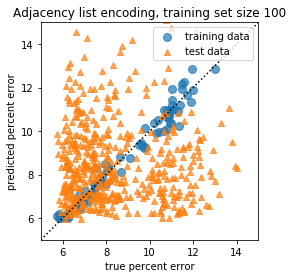

Meta neuralnet training size: 100, encode paths: True
Train error: 0.33, test error: 1.031


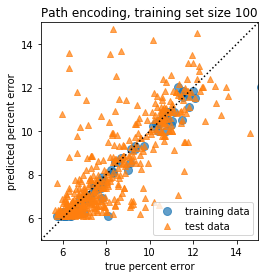

Meta neuralnet training size: 500, encode paths: False
Train error: 0.467, test error: 2.442


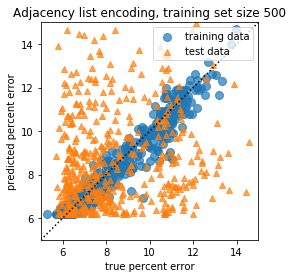

Meta neuralnet training size: 500, encode paths: True
Train error: 0.285, test error: 0.976


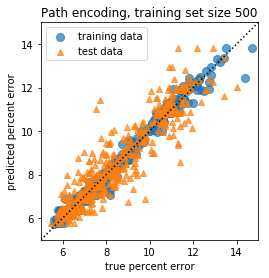

In [6]:
# try out your favorite hyperparameter settings to get the best accuracy on NASBench
meta_neuralnet_params = {'loss':'mae', 'num_layers':10, 'layer_width':20, 'epochs':200, \
                         'batch_size':32, 'lr':.01, 'regularization':0, 'verbose':0}
ns = [100, 500]

# takes about 1 minute
meta_neuralnet_experiment(meta_neuralnet_params, ns)

In [7]:
train_data = search_space.generate_random_dataset(num=500, 
                                                  encode_paths=True)

In [10]:
test_data = search_space.generate_random_dataset(num=3000, 
                                                encode_paths=True)

In [11]:
len(search_space.nasbench.fixed_statistics.keys())

423624

In [12]:
np.random.seed(0)
sample_keys = np.random.choice(list(search_space.nasbench.fixed_statistics.keys()), 3000)

In [13]:
from nas_bench.cell import Cell

In [14]:
from tqdm import tqdm_notebook

In [15]:
test_data_2 = []
for k in tqdm_notebook(sample_keys):
    m = search_space.nasbench.get_metrics_from_hash(k)
    if len(m[0]['module_operations']) == 7:
        arch = {'matrix':m[0]['module_adjacency'], 'ops':m[0]['module_operations']}
        archtuple = search_space.query_arch(arch, 
                                            train=True,
                                            encode_paths=True,
                                            deterministic=True)
        test_data_2.append(archtuple)

In [18]:
len(train_data)

500

In [16]:
len(test_data_2)

2518

In [17]:
len(test_data)

3000

In [20]:
xtrain = np.array([d[1] for d in train_data])
ytrain = np.array([d[2] for d in train_data])

In [21]:
xtest = np.array([d[1] for d in test_data])
ytest = np.array([d[2] for d in test_data])

In [22]:
xtest_2 = np.array([d[1] for d in test_data_2])
ytest_2 = np.array([d[2] for d in test_data_2])

In [23]:
#

In [24]:
model = MetaNeuralnet()
model.fit(xtrain, ytrain, **meta_neuralnet_params)

0.2461794261932373

In [25]:
train_pred = np.squeeze(model.predict(xtrain))
train_error = np.mean(abs(train_pred-ytrain))
test_pred = np.squeeze(model.predict(xtest))        
test_error = np.mean(abs(test_pred-ytest))
print(train_error, test_error)

0.2461794261932373 0.9110589078585305


In [26]:
test_pred_2 = np.squeeze(model.predict(xtest_2))        
test_error_2 = np.mean(abs(test_pred_2-ytest_2))
print(test_error_2)

3.071763700835188


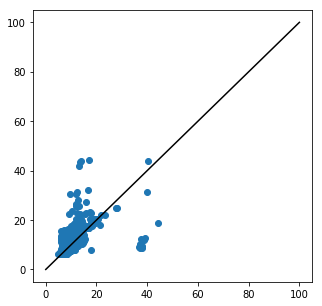

In [27]:
plt.figure(figsize=(5, 5))
plt.scatter(ytest, test_pred)
plt.plot([0, 100], [0, 100], color='k')

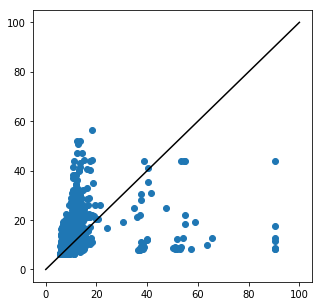

In [28]:
plt.figure(figsize=(5, 5))
plt.scatter(ytest_2, test_pred_2)
plt.plot([0, 100], [0, 100], color='k')